In [69]:
# Numerical analysis
import numpy as np
import jax.lax as lax
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

# Dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(0)

# MODEL CONSTANTS
n_realizations = 5

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 2

# TESTING
lams = [1/2, 1/10, 1/500, 1/10000]
sigma = 1
p = 5/7

In [70]:
# Load data file
dset = pd.read_csv("data/azdiabetes.csv", sep=",")

def standardize(x):
    return (x-x.mean(0)) / x.std(0)

y = dset["diabetes one-hot"].values
X = dset[["npreg", "glu", "bp", "skin", "bmi", "ped", "age"]].values

X = standardize(X)


<h2> Defining the Model </h2>

In [71]:
def model(alphas, lam, X, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter, Dx1
       array X: input data, NxD
       array y: output data, Nx1
    '''
    D = X.shape[1]
    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D]))
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1-U))
    T = numpyro.deterministic("T", jnp.log(alphas) - jnp.log(1-alphas))
    z_lam = numpyro.deterministic("z_lam", ((lam**2+lam+1)/(lam+1)) * T + L)

    gammas = numpyro.deterministic("gammas", sigmoid(z_lam/lam))
    y_mean = jnp.dot(X, gammas) #Nx1
    y = numpyro.sample("y", dist.Bernoulli(logits=y_mean), obs=y) 

In [72]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [73]:
def concrete(X, y, lam):
    '''
    Parameters:
       dict all_data: keys are integers and values are the corresponding tuple (X, Y)
       int lam: temperature coefficient
    
    Returns:
       arr mses: size (D,)
       arr kappas: length len(A_values) * D
       arr mean_gammas: size (D,)
       arr betas: size (D,)
       dict samples: keys are sampled values in the mcmc model, values are the samples
       mcmc: a Numpyro MCMC object

    '''
    k = (lam**2+lam+1) / (lam+1)
    numerator = (p/(1-p))**(1/k)
    denominator = 1 + (p/(1-p))**(1/k)
    alphas = jnp.zeros(X.shape[1])
    alphas += (numerator / denominator)
    mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, y=y)
    samples = mcmc.get_samples()
    mean_gammas =  samples["gammas"]
   #  plt.figure(figsize=(12, 6))
   #  plt.subplot(1, 2, 1)
   #  sns.histplot(mean_gammas, kde=True)
   #  plt.title('Distribution of Mean Gammas')
   #  plt.tight_layout()
   #  plt.show()
    print(mean_gammas)
    return mean_gammas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [74]:
all_mses = dict()
mean_mses = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for _ in range(n_realizations):
    for lam in lams:
        gammas, all_samples, mcmc = concrete(X, y, lam=lam)
        if lam not in mean_gammas:
            mean_gammas[lam] = []
        mean_gammas[lam].append(gammas)
        all_mcmc_runs.append(mcmc)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5238.95it/s, 15 steps of size 2.53e-01. acc. prob=0.95]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are availab

[[4.3212560e-01 9.9999702e-01 4.5390730e-04 ... 4.5846167e-01
  3.0658108e-01 1.0535437e-02]
 [7.4644393e-01 9.9940252e-01 3.0881821e-04 ... 4.8913503e-01
  5.3643864e-01 1.9733550e-02]
 [5.5110198e-01 9.9985063e-01 2.0348693e-03 ... 4.2774010e-01
  5.6801099e-01 8.7931119e-03]
 ...
 [3.9720359e-01 9.6280587e-01 1.3556537e-02 ... 2.6605007e-01
  3.8834858e-01 1.2860300e-01]
 [3.6993551e-01 9.4177186e-01 1.5683377e-01 ... 5.5209810e-01
  4.7779116e-01 1.9601266e-01]
 [5.1560116e-01 9.9300885e-01 7.4806199e-03 ... 4.8993430e-01
  6.8363470e-01 8.1058912e-02]]


sample: 100%|██████████| 1500/1500 [00:00<00:00, 2347.31it/s, 63 steps of size 6.22e-02. acc. prob=0.94]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[7.23059595e-01 1.00000000e+00 3.27599743e-08 ... 5.23661137e-01
  1.46225244e-01 2.75496774e-07]
 [7.98134267e-01 1.00000000e+00 1.53500400e-02 ... 3.55189472e-01
  2.37771153e-01 9.83016193e-03]
 [4.03124183e-01 1.00000000e+00 8.84885196e-07 ... 5.48854470e-01
  6.65830612e-01 2.43999766e-05]
 ...
 [5.45603216e-01 1.00000000e+00 9.02208686e-03 ... 6.00758970e-01
  4.54276592e-01 6.86968267e-02]
 [5.55816233e-01 1.00000000e+00 7.29598999e-02 ... 6.23183846e-01
  4.64139253e-01 1.08780645e-01]
 [3.80649239e-01 9.99999523e-01 2.04670971e-04 ... 5.16510725e-01
  3.41324329e-01 1.85649350e-01]]


sample: 100%|██████████| 1500/1500 [00:02<00:00, 550.51it/s, 187 steps of size 1.39e-02. acc. prob=0.80]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 3.6302000e-01
  2.1353756e-01 5.4734033e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 5.5234158e-01
  4.2349944e-01 3.1729788e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 4.8464176e-01
  3.8635001e-01 3.1203434e-01]
 ...
 [5.7037717e-01 1.0000000e+00 1.9988704e-13 ... 4.9350351e-01
  4.4415349e-01 0.0000000e+00]
 [5.7655877e-01 1.0000000e+00 3.4813839e-03 ... 5.0712228e-01
  4.4823325e-01 0.0000000e+00]
 [4.8143423e-01 1.0000000e+00 0.0000000e+00 ... 4.9975413e-01
  5.1289409e-01 0.0000000e+00]]


sample: 100%|██████████| 1500/1500 [00:08<00:00, 177.54it/s, 556 steps of size 2.88e-03. acc. prob=0.78] 
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.         1.         0.         ... 0.35565838 0.         0.67221844]
 [0.         1.         0.         ... 0.65761214 0.         0.5183202 ]
 [0.         1.         0.         ... 0.35116374 0.         0.57788974]
 ...
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]]


sample: 100%|██████████| 1500/1500 [00:00<00:00, 5671.89it/s, 15 steps of size 2.53e-01. acc. prob=0.95]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[4.3212560e-01 9.9999702e-01 4.5390730e-04 ... 4.5846167e-01
  3.0658108e-01 1.0535437e-02]
 [7.4644393e-01 9.9940252e-01 3.0881821e-04 ... 4.8913503e-01
  5.3643864e-01 1.9733550e-02]
 [5.5110198e-01 9.9985063e-01 2.0348693e-03 ... 4.2774010e-01
  5.6801099e-01 8.7931119e-03]
 ...
 [3.9720359e-01 9.6280587e-01 1.3556537e-02 ... 2.6605007e-01
  3.8834858e-01 1.2860300e-01]
 [3.6993551e-01 9.4177186e-01 1.5683377e-01 ... 5.5209810e-01
  4.7779116e-01 1.9601266e-01]
 [5.1560116e-01 9.9300885e-01 7.4806199e-03 ... 4.8993430e-01
  6.8363470e-01 8.1058912e-02]]


sample: 100%|██████████| 1500/1500 [00:00<00:00, 2552.06it/s, 63 steps of size 6.22e-02. acc. prob=0.94]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[7.23059595e-01 1.00000000e+00 3.27599743e-08 ... 5.23661137e-01
  1.46225244e-01 2.75496774e-07]
 [7.98134267e-01 1.00000000e+00 1.53500400e-02 ... 3.55189472e-01
  2.37771153e-01 9.83016193e-03]
 [4.03124183e-01 1.00000000e+00 8.84885196e-07 ... 5.48854470e-01
  6.65830612e-01 2.43999766e-05]
 ...
 [5.45603216e-01 1.00000000e+00 9.02208686e-03 ... 6.00758970e-01
  4.54276592e-01 6.86968267e-02]
 [5.55816233e-01 1.00000000e+00 7.29598999e-02 ... 6.23183846e-01
  4.64139253e-01 1.08780645e-01]
 [3.80649239e-01 9.99999523e-01 2.04670971e-04 ... 5.16510725e-01
  3.41324329e-01 1.85649350e-01]]


sample: 100%|██████████| 1500/1500 [00:03<00:00, 408.59it/s, 187 steps of size 1.39e-02. acc. prob=0.80] 
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 3.6302000e-01
  2.1353756e-01 5.4734033e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 5.5234158e-01
  4.2349944e-01 3.1729788e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 4.8464176e-01
  3.8635001e-01 3.1203434e-01]
 ...
 [5.7037717e-01 1.0000000e+00 1.9988704e-13 ... 4.9350351e-01
  4.4415349e-01 0.0000000e+00]
 [5.7655877e-01 1.0000000e+00 3.4813839e-03 ... 5.0712228e-01
  4.4823325e-01 0.0000000e+00]
 [4.8143423e-01 1.0000000e+00 0.0000000e+00 ... 4.9975413e-01
  5.1289409e-01 0.0000000e+00]]


sample: 100%|██████████| 1500/1500 [00:08<00:00, 167.17it/s, 556 steps of size 2.88e-03. acc. prob=0.78] 
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.         1.         0.         ... 0.35565838 0.         0.67221844]
 [0.         1.         0.         ... 0.65761214 0.         0.5183202 ]
 [0.         1.         0.         ... 0.35116374 0.         0.57788974]
 ...
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]]


sample: 100%|██████████| 1500/1500 [00:00<00:00, 4668.10it/s, 15 steps of size 2.53e-01. acc. prob=0.95]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[4.3212560e-01 9.9999702e-01 4.5390730e-04 ... 4.5846167e-01
  3.0658108e-01 1.0535437e-02]
 [7.4644393e-01 9.9940252e-01 3.0881821e-04 ... 4.8913503e-01
  5.3643864e-01 1.9733550e-02]
 [5.5110198e-01 9.9985063e-01 2.0348693e-03 ... 4.2774010e-01
  5.6801099e-01 8.7931119e-03]
 ...
 [3.9720359e-01 9.6280587e-01 1.3556537e-02 ... 2.6605007e-01
  3.8834858e-01 1.2860300e-01]
 [3.6993551e-01 9.4177186e-01 1.5683377e-01 ... 5.5209810e-01
  4.7779116e-01 1.9601266e-01]
 [5.1560116e-01 9.9300885e-01 7.4806199e-03 ... 4.8993430e-01
  6.8363470e-01 8.1058912e-02]]


sample: 100%|██████████| 1500/1500 [00:01<00:00, 1457.40it/s, 63 steps of size 6.22e-02. acc. prob=0.94]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[7.23059595e-01 1.00000000e+00 3.27599743e-08 ... 5.23661137e-01
  1.46225244e-01 2.75496774e-07]
 [7.98134267e-01 1.00000000e+00 1.53500400e-02 ... 3.55189472e-01
  2.37771153e-01 9.83016193e-03]
 [4.03124183e-01 1.00000000e+00 8.84885196e-07 ... 5.48854470e-01
  6.65830612e-01 2.43999766e-05]
 ...
 [5.45603216e-01 1.00000000e+00 9.02208686e-03 ... 6.00758970e-01
  4.54276592e-01 6.86968267e-02]
 [5.55816233e-01 1.00000000e+00 7.29598999e-02 ... 6.23183846e-01
  4.64139253e-01 1.08780645e-01]
 [3.80649239e-01 9.99999523e-01 2.04670971e-04 ... 5.16510725e-01
  3.41324329e-01 1.85649350e-01]]


sample: 100%|██████████| 1500/1500 [00:02<00:00, 675.92it/s, 187 steps of size 1.39e-02. acc. prob=0.80]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 3.6302000e-01
  2.1353756e-01 5.4734033e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 5.5234158e-01
  4.2349944e-01 3.1729788e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 4.8464176e-01
  3.8635001e-01 3.1203434e-01]
 ...
 [5.7037717e-01 1.0000000e+00 1.9988704e-13 ... 4.9350351e-01
  4.4415349e-01 0.0000000e+00]
 [5.7655877e-01 1.0000000e+00 3.4813839e-03 ... 5.0712228e-01
  4.4823325e-01 0.0000000e+00]
 [4.8143423e-01 1.0000000e+00 0.0000000e+00 ... 4.9975413e-01
  5.1289409e-01 0.0000000e+00]]


sample: 100%|██████████| 1500/1500 [00:08<00:00, 170.59it/s, 556 steps of size 2.88e-03. acc. prob=0.78] 
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.         1.         0.         ... 0.35565838 0.         0.67221844]
 [0.         1.         0.         ... 0.65761214 0.         0.5183202 ]
 [0.         1.         0.         ... 0.35116374 0.         0.57788974]
 ...
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]]


sample: 100%|██████████| 1500/1500 [00:00<00:00, 5575.12it/s, 15 steps of size 2.53e-01. acc. prob=0.95]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[4.3212560e-01 9.9999702e-01 4.5390730e-04 ... 4.5846167e-01
  3.0658108e-01 1.0535437e-02]
 [7.4644393e-01 9.9940252e-01 3.0881821e-04 ... 4.8913503e-01
  5.3643864e-01 1.9733550e-02]
 [5.5110198e-01 9.9985063e-01 2.0348693e-03 ... 4.2774010e-01
  5.6801099e-01 8.7931119e-03]
 ...
 [3.9720359e-01 9.6280587e-01 1.3556537e-02 ... 2.6605007e-01
  3.8834858e-01 1.2860300e-01]
 [3.6993551e-01 9.4177186e-01 1.5683377e-01 ... 5.5209810e-01
  4.7779116e-01 1.9601266e-01]
 [5.1560116e-01 9.9300885e-01 7.4806199e-03 ... 4.8993430e-01
  6.8363470e-01 8.1058912e-02]]


sample: 100%|██████████| 1500/1500 [00:00<00:00, 2617.40it/s, 63 steps of size 6.22e-02. acc. prob=0.94]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[7.23059595e-01 1.00000000e+00 3.27599743e-08 ... 5.23661137e-01
  1.46225244e-01 2.75496774e-07]
 [7.98134267e-01 1.00000000e+00 1.53500400e-02 ... 3.55189472e-01
  2.37771153e-01 9.83016193e-03]
 [4.03124183e-01 1.00000000e+00 8.84885196e-07 ... 5.48854470e-01
  6.65830612e-01 2.43999766e-05]
 ...
 [5.45603216e-01 1.00000000e+00 9.02208686e-03 ... 6.00758970e-01
  4.54276592e-01 6.86968267e-02]
 [5.55816233e-01 1.00000000e+00 7.29598999e-02 ... 6.23183846e-01
  4.64139253e-01 1.08780645e-01]
 [3.80649239e-01 9.99999523e-01 2.04670971e-04 ... 5.16510725e-01
  3.41324329e-01 1.85649350e-01]]


sample: 100%|██████████| 1500/1500 [00:03<00:00, 387.64it/s, 187 steps of size 1.39e-02. acc. prob=0.80]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 3.6302000e-01
  2.1353756e-01 5.4734033e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 5.5234158e-01
  4.2349944e-01 3.1729788e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 4.8464176e-01
  3.8635001e-01 3.1203434e-01]
 ...
 [5.7037717e-01 1.0000000e+00 1.9988704e-13 ... 4.9350351e-01
  4.4415349e-01 0.0000000e+00]
 [5.7655877e-01 1.0000000e+00 3.4813839e-03 ... 5.0712228e-01
  4.4823325e-01 0.0000000e+00]
 [4.8143423e-01 1.0000000e+00 0.0000000e+00 ... 4.9975413e-01
  5.1289409e-01 0.0000000e+00]]


sample: 100%|██████████| 1500/1500 [00:07<00:00, 190.24it/s, 556 steps of size 2.88e-03. acc. prob=0.78] 
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.         1.         0.         ... 0.35565838 0.         0.67221844]
 [0.         1.         0.         ... 0.65761214 0.         0.5183202 ]
 [0.         1.         0.         ... 0.35116374 0.         0.57788974]
 ...
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]]


sample: 100%|██████████| 1500/1500 [00:00<00:00, 5747.22it/s, 15 steps of size 2.53e-01. acc. prob=0.95]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[4.3212560e-01 9.9999702e-01 4.5390730e-04 ... 4.5846167e-01
  3.0658108e-01 1.0535437e-02]
 [7.4644393e-01 9.9940252e-01 3.0881821e-04 ... 4.8913503e-01
  5.3643864e-01 1.9733550e-02]
 [5.5110198e-01 9.9985063e-01 2.0348693e-03 ... 4.2774010e-01
  5.6801099e-01 8.7931119e-03]
 ...
 [3.9720359e-01 9.6280587e-01 1.3556537e-02 ... 2.6605007e-01
  3.8834858e-01 1.2860300e-01]
 [3.6993551e-01 9.4177186e-01 1.5683377e-01 ... 5.5209810e-01
  4.7779116e-01 1.9601266e-01]
 [5.1560116e-01 9.9300885e-01 7.4806199e-03 ... 4.8993430e-01
  6.8363470e-01 8.1058912e-02]]


sample: 100%|██████████| 1500/1500 [00:00<00:00, 1732.66it/s, 63 steps of size 6.22e-02. acc. prob=0.94]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[7.23059595e-01 1.00000000e+00 3.27599743e-08 ... 5.23661137e-01
  1.46225244e-01 2.75496774e-07]
 [7.98134267e-01 1.00000000e+00 1.53500400e-02 ... 3.55189472e-01
  2.37771153e-01 9.83016193e-03]
 [4.03124183e-01 1.00000000e+00 8.84885196e-07 ... 5.48854470e-01
  6.65830612e-01 2.43999766e-05]
 ...
 [5.45603216e-01 1.00000000e+00 9.02208686e-03 ... 6.00758970e-01
  4.54276592e-01 6.86968267e-02]
 [5.55816233e-01 1.00000000e+00 7.29598999e-02 ... 6.23183846e-01
  4.64139253e-01 1.08780645e-01]
 [3.80649239e-01 9.99999523e-01 2.04670971e-04 ... 5.16510725e-01
  3.41324329e-01 1.85649350e-01]]


sample: 100%|██████████| 1500/1500 [00:02<00:00, 568.54it/s, 187 steps of size 1.39e-02. acc. prob=0.80]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


[[0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 3.6302000e-01
  2.1353756e-01 5.4734033e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 5.5234158e-01
  4.2349944e-01 3.1729788e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 4.8464176e-01
  3.8635001e-01 3.1203434e-01]
 ...
 [5.7037717e-01 1.0000000e+00 1.9988704e-13 ... 4.9350351e-01
  4.4415349e-01 0.0000000e+00]
 [5.7655877e-01 1.0000000e+00 3.4813839e-03 ... 5.0712228e-01
  4.4823325e-01 0.0000000e+00]
 [4.8143423e-01 1.0000000e+00 0.0000000e+00 ... 4.9975413e-01
  5.1289409e-01 0.0000000e+00]]


sample: 100%|██████████| 1500/1500 [00:09<00:00, 164.02it/s, 556 steps of size 2.88e-03. acc. prob=0.78] 

[[0.         1.         0.         ... 0.35565838 0.         0.67221844]
 [0.         1.         0.         ... 0.65761214 0.         0.5183202 ]
 [0.         1.         0.         ... 0.35116374 0.         0.57788974]
 ...
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]
 [1.         1.         0.         ... 1.         1.         0.        ]]


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [75]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.24      0.06      0.24      0.14      0.35    820.24      1.00
      U[1]      0.76      0.14      0.78      0.56      1.00   1160.38      1.00
      U[2]      0.06      0.04      0.06      0.00      0.12   1041.69      1.00
      U[3]      0.09      0.06      0.08      0.00      0.17    974.88      1.00
      U[4]      0.26      0.06      0.26      0.17      0.35   1333.50      1.00
      U[5]      0.27      0.06      0.27      0.19      0.36   1147.25      1.00
      U[6]      0.15      0.07      0.15      0.02      0.25    920.82      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.28      0.02      0.28      0.26      0.31    321.41      1.00
      U[1]      0.66      0.19      0.66      0.37      0.96    576.96      1.00
      U[2]      0.12      0.07      0.13      0.00      0.22    484.08      1.00


<h1> Results </h1>

0.5 [0.38749203 0.96876067 0.03986249 0.0824798  0.43332738 0.46470627
 0.18157645]
0.1 [0.45929134 0.99594784 0.00927643 0.01828809 0.4795513  0.46005967
 0.08765768]
0.002 [4.92082059e-01 9.99948621e-01 9.99379336e-05 2.26321383e-04
 5.05242765e-01 4.27492410e-01 1.02557436e-01]
0.0001 [5.0000000e-01 1.0000000e+00 2.7015523e-09 2.7753564e-09 7.2983849e-01
 5.0000000e-01 2.4165118e-01]


(-0.05, 1.05)

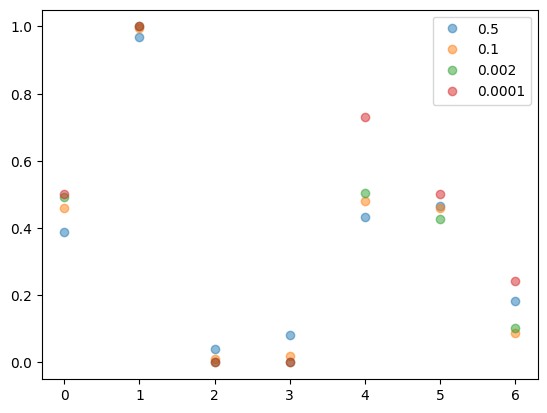

In [76]:
# for gamma in mean_gammas:
#     plt.plot(mean_gammas.keys(), mean_gammas.values(), '.', label=gamma, alpha=0.5)
# plt.legend()
# plt.title("Gamma values for different lambdas")
# plt.ylabel("Gamma")
# plt.xlabel("Entry #")

for lam in lams: 
    # for x in mean_gammas[lam]:
    #     plt.plot(x, '.', label=lam)
    #     # print(lam, mean_gammas[lam])
    plt.plot(np.array(mean_gammas[lam]).mean(0).mean(0), 'o', label=lam, alpha=0.5)
    print(lam, np.array(mean_gammas[lam]).mean(0).mean(0))

plt.legend()
plt.ylim(-0.05, 1.05)

In [77]:
y = dict()
for i in range(7):
    y[i] = dict()

for lam in lams:
    mean_gammas[lam] = np.array(mean_gammas[lam])
    for i in range(7):
        y[i][lam] = np.ndarray.flatten(mean_gammas[lam][:, :, i])

In [78]:
y[0][0.5].shape

(10000,)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_51664/4273958901.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y[1][lam], ax=axs[0,1])


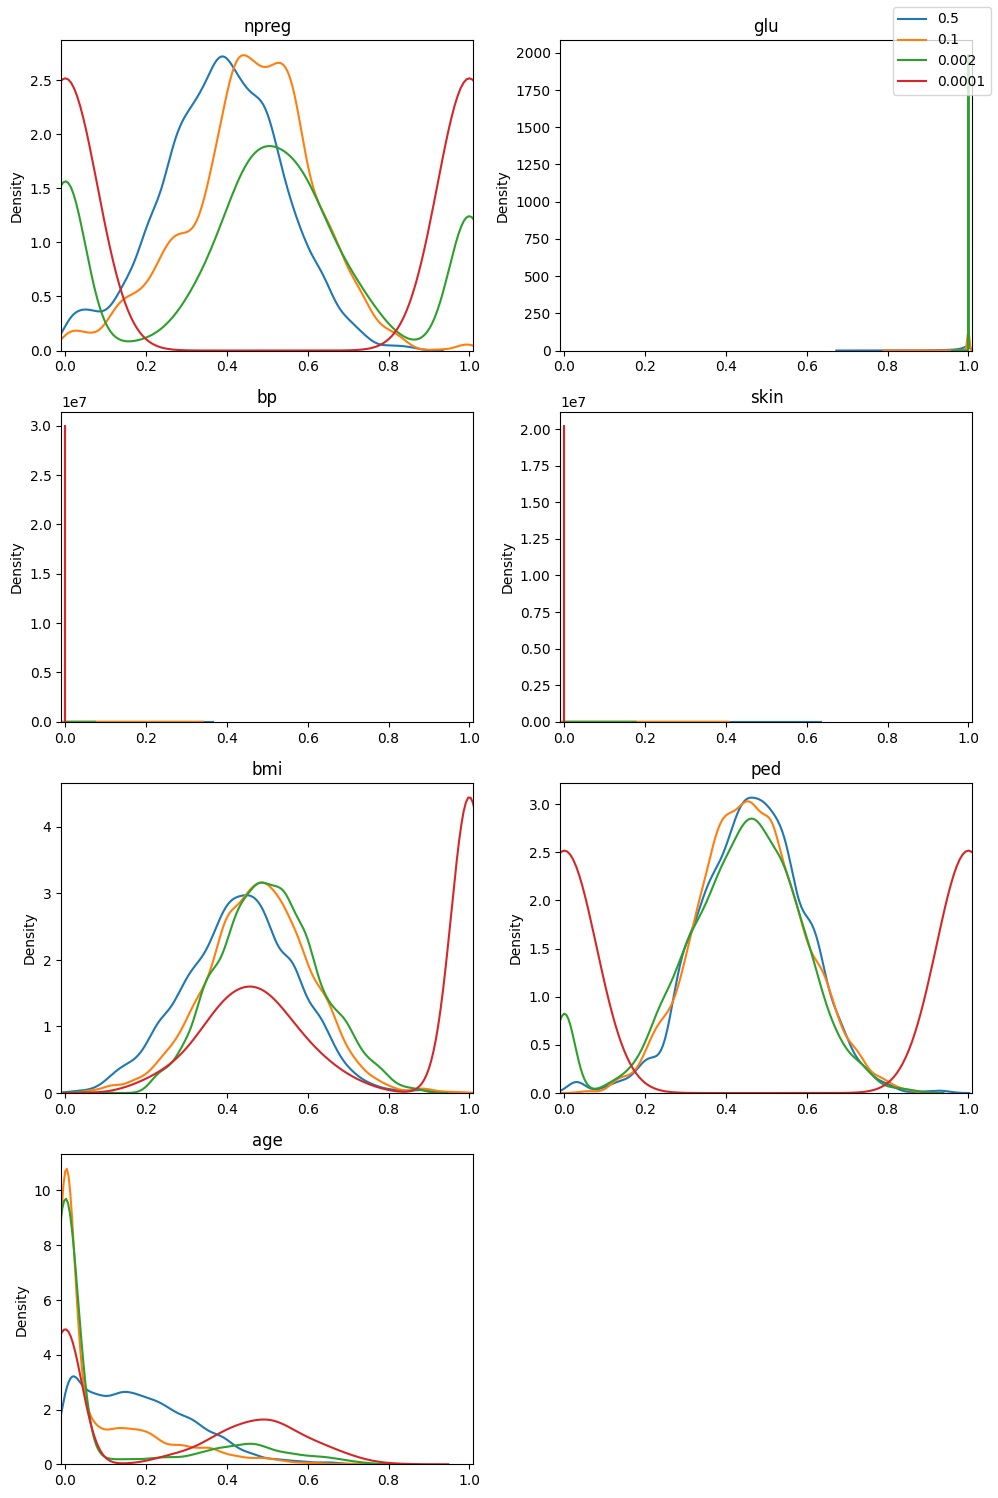

In [97]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)

for lam in lams:
    sns.kdeplot(y[0][lam], ax=axs[0,0], label=f'{lam}')
    sns.kdeplot(y[1][lam], ax=axs[0,1])
    sns.kdeplot(y[2][lam], ax=axs[1,0])
    sns.kdeplot(y[3][lam], ax=axs[1,1])
    sns.kdeplot(y[4][lam], ax=axs[2,0])
    sns.kdeplot(y[5][lam], ax=axs[2,1])
    sns.kdeplot(y[6][lam], ax=axs[3,0])

for ax in axs.flat:
    ax.set_xlim(-0.01, 1.01)

axs[0,0].set_title("npreg")
axs[0,1].set_title("glu")
axs[1,0].set_title("bp")
axs[1,1].set_title("skin")
axs[2,0].set_title("bmi")
axs[2,1].set_title("ped")
axs[3,0].set_title("age")

plt.tight_layout()
fig.delaxes(axs[3, 1]) # deletes unused 8th subplot
fig.legend()

In [ ]:
# samples_1 = mcmc.get_samples()
# predictive = Predictive(model, samples_1)
# predictions = predictive(random.PRNGKey(1),
#                          alphas = jnp.ones(X.shape[1]),
#                          lam=10000, 
#                          X=X,
#                          y=y)['y']
# mean_pred = predictions.mean(0)

# plt.plot(mean_pred, '.')
# plt.plot(y, '.')

# print(sum((mean_pred - y)**2))